### ATTENTION MECHANISM CON EL DATASET GRANDE

### attention autoencoder con TODOS LOS DATOS

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import zipfile
import builtins
from tensorflow.keras.utils import to_categorical

In [22]:
# Hiperparámetros
batch_size = 32
lr = 1e-3
epochs = 10
kr = 1e-4  # Regularización L1
drop_prec = 0.25  # Dropout

In [23]:
# Cargar y procesar los datos

def unzip(archivo_zip, variable_name):
    """
    Extrae y carga el contenido del único archivo dentro de un ZIP en una variable global.
    
    Parámetros:
    - archivo_zip: Ruta al archivo ZIP.
    - variable_name: Nombre de la variable global donde se guardará el DataFrame.
    """
    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        # Obtiene directamente el primer (y único) archivo
        file_name = zip_ref.namelist()[0]
        with zip_ref.open(file_name) as txt_file:
            # Leer el archivo como un DataFrame de pandas
            df = pd.read_csv(txt_file, sep='\t', index_col=0)
            
            # Asignar el DataFrame a una variable global con el nombre proporcionado
            builtins.__dict__[variable_name] = df

In [24]:

# path de descompresión
zip_file_train= '../data/raw/yeast_genotype_train.txt.zip'
# Llamar a la función para descomprimir y guardar los DataFrames en variable globale
unzip(zip_file_train, 'df_train') 

In [25]:

df_onehot = tf.keras.utils.to_categorical(df_train)
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

In [26]:

# Dimensiones de entrada
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
input_shape = (feature_size, inChannel)

# Codificador con atención
inputs = Input(shape=input_shape)
inputs

<KerasTensor shape=(None, 28220, 3), dtype=float32, sparse=False, name=keras_tensor_16>

In [27]:
# Capas convolucionales del encoder
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)

# Mecanismo de atención
def attention_1d(inputs):
    # Capa densa para generar los pesos de atención
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Multiplicar las activaciones convolucionales por los pesos de atención
    attention = Multiply()([inputs, attention])
    return attention

# Aplicar la atención después del codificador
x = attention_1d(x)

In [28]:
# Decodificador convolucional
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
outputs = Conv1D(inChannel, 5, activation='softmax', padding='same')(x)


In [29]:
# Definir el modelo
attention_model = Model(inputs, outputs)

In [30]:
# Compilar el modelo
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28220, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 28220, 32) │        512 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 14110, 32) │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14110, 32) │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 14110, 64) │     10,304 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 7055, 64)  │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 7055, 64)  │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 7055, 128) │     41,088 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7055, 128) │     16,512 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7055, 128) │          0 │ conv1d_8[0][0],   │
│ (Multiply)          │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 7055, 64)  │     41,024 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_2     │ (None, 14110, 64) │          0 │ conv1d_9[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 14110, 32) │     10,272 │ up_sampling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_3     │ (None, 28220, 32) │          0 │ conv1d_10[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 28220, 3)  │        483 │ up_sampling1d_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,195 (469.51 KB)

 Trainable params: 120,195 (469.51 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:

# Definir DataGenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [32]:

# Entrenamiento
train_generator = DataGenerator(batch_size=batch_size, x_dataset=train_X, missing_perc=0.1)
valid_generator = DataGenerator(batch_size=batch_size, x_dataset=valid_X, missing_perc=0.1)


In [ ]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [33]:
attention_model_train = attention_model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,
    callbacks= [EarlyStopping]
    
)

Epoch 1/10


/Users/celiacabello/miniconda3/envs/TFM/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 840ms/step - accuracy: 0.6159 - loss: 1.0256 - val_accuracy: 0.9989 - val_loss: 0.1069
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 854ms/step - accuracy: 0.9980 - loss: 0.0929 - val_accuracy: 0.9993 - val_loss: 0.0648
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 856ms/step - accuracy: 0.9981 - loss: 0.0613 - val_accuracy: 0.9994 - val_loss: 0.0487
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 844ms/step - accuracy: 0.9981 - loss: 0.0477 - val_accuracy: 0.9993 - val_loss: 0.0396
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 845ms/step - accuracy: 0.9982 - loss: 0.0394 - val_accuracy: 0.9994 - val_loss: 0.0337
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 864ms/step - accuracy: 0.9983 - loss: 0.0337 - val_accuracy: 0.9993 - val_loss: 0.0291
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 891ms/step - accuracy: 0.9984 - loss: 0.0294 - val_accuracy: 0.9995 - val_loss: 0.0254
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 852ms/step - accuracy: 0.9985 - loss: 0.0259 - val_accuracy: 0.999

### plotting

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_19491/68356141.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")


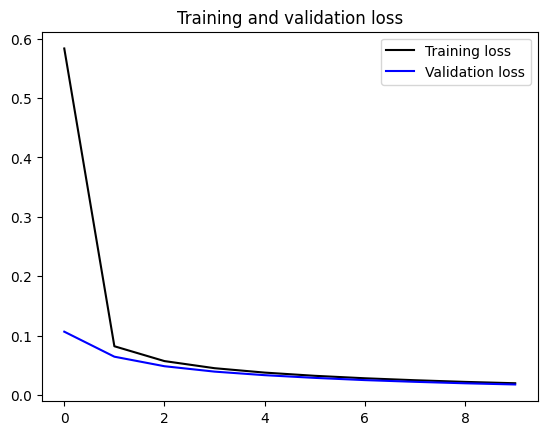

In [38]:
# plot loss curve on validation data
loss = attention_model_train.history['loss']
val_loss = attention_model_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_19491/3295592865.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_19491/3295592865.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")


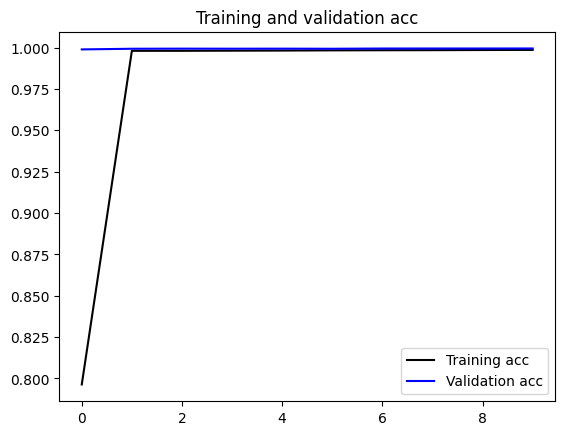

In [39]:
# function modified -- key "acc" did not exist. the correct key is 
# plot accuracy curve on validation data
print(attention_model_train.history.keys())
acc = attention_model_train.history['accuracy'] #initially the key was acc
val_acc = attention_model_train.history['val_accuracy']#initially the key was val_ acc
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [40]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.020074892789125443
Final Validation Loss: 0.018005670979619026
Final Training Accuracy: 0.9986251592636108
Final Validation Accuracy: 0.9994877576828003


### Training

### TESTING

In [44]:
# path de descompresión
zip_file_train= '../data/raw/yeast_genotype_test.txt.zip'
# Llamar a la función para descomprimir y guardar los DataFrames en variable globale
unzip(zip_file_train, 'df_test') 
test_X = to_categorical(df_test)
test_X.shape

(877, 28220, 3)

In [45]:
import numpy as np

# Porcentajes de pérdida
missing_perc_list = [0.1, 0.2, 0.3, 0.4]

# Función para calcular la probabilidad de los genotipos 0, 1, 2
def cal_prob(predict_missing_onehot):
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob

# Diccionario para almacenar los resultados de precisión por cada porcentaje
accuracy_summary = {}

# Iterar sobre los porcentajes de datos faltantes
for missing_perc in missing_perc_list:
    avg_accuracy = []
    
    # Generar índices faltantes de una vez para todas las muestras
    num_samples = test_X.shape[0]
    missing_indices = [np.random.randint(test_X.shape[1], size=int(missing_perc * test_X.shape[1])) for _ in range(num_samples)]
    
    # Generar la matriz con datos faltantes en un solo paso
    test_X_missing = test_X.copy()
    for i in range(num_samples):
        test_X_missing[i, missing_indices[i], :] = [1, 0, 0]  # Generar genotipos faltantes
    
    # Predecir utilizando el modelo entrenado en lotes en lugar de predicciones individuales
    predict_onehot = attention_model.predict(test_X_missing, batch_size=32)  # Ajustar el tamaño del batch si es necesario
    
    # Iterar sobre cada muestra para calcular las precisiones
    for i in range(num_samples):
        # Solo se consideran las posiciones faltantes
        predict_missing_onehot = predict_onehot[i:i + 1, missing_indices[i], :]
        
        # Predicción de la etiqueta
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # Etiqueta real
        label_missing_onehot = test_X[i:i + 1, missing_indices[i], :]
        label_missing = np.argmax(label_missing_onehot, axis=2)

        # Calcular la precisión
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        avg_accuracy.append(accuracy)

    # Guardar la precisión promedio para el porcentaje actual
    accuracy_summary[missing_perc] = np.mean(avg_accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step


In [46]:
# Mostrar el resumen de las precisiones promedio
print("\n=== Resumen de precisión promedio por porcentaje de pérdida ===")
for perc, acc in accuracy_summary.items():
    print(f'Porcentaje de pérdida: {perc * 100}%, Precisión promedio: {acc:.4f}')


=== Resumen de precisión promedio por porcentaje de pérdida ===
Porcentaje de pérdida: 10.0%, Precisión promedio: 0.9978
Porcentaje de pérdida: 20.0%, Precisión promedio: 0.9977
Porcentaje de pérdida: 30.0%, Precisión promedio: 0.9973
Porcentaje de pérdida: 40.0%, Precisión promedio: 0.9969
